</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import time

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

## Подготовка

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.index.is_monotonic

Данные уже загружены отсрортированно по дате.

In [4]:
data.head()

In [5]:
data.describe()

In [6]:
data.info()

In [7]:
data.isna().sum()

Пропусков в данных не наблюдается.

In [8]:
data = data.resample('1H').sum()

Создадим признаки.

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
make_features(data, 20, 5)

In [11]:
data.head()

## Анализ

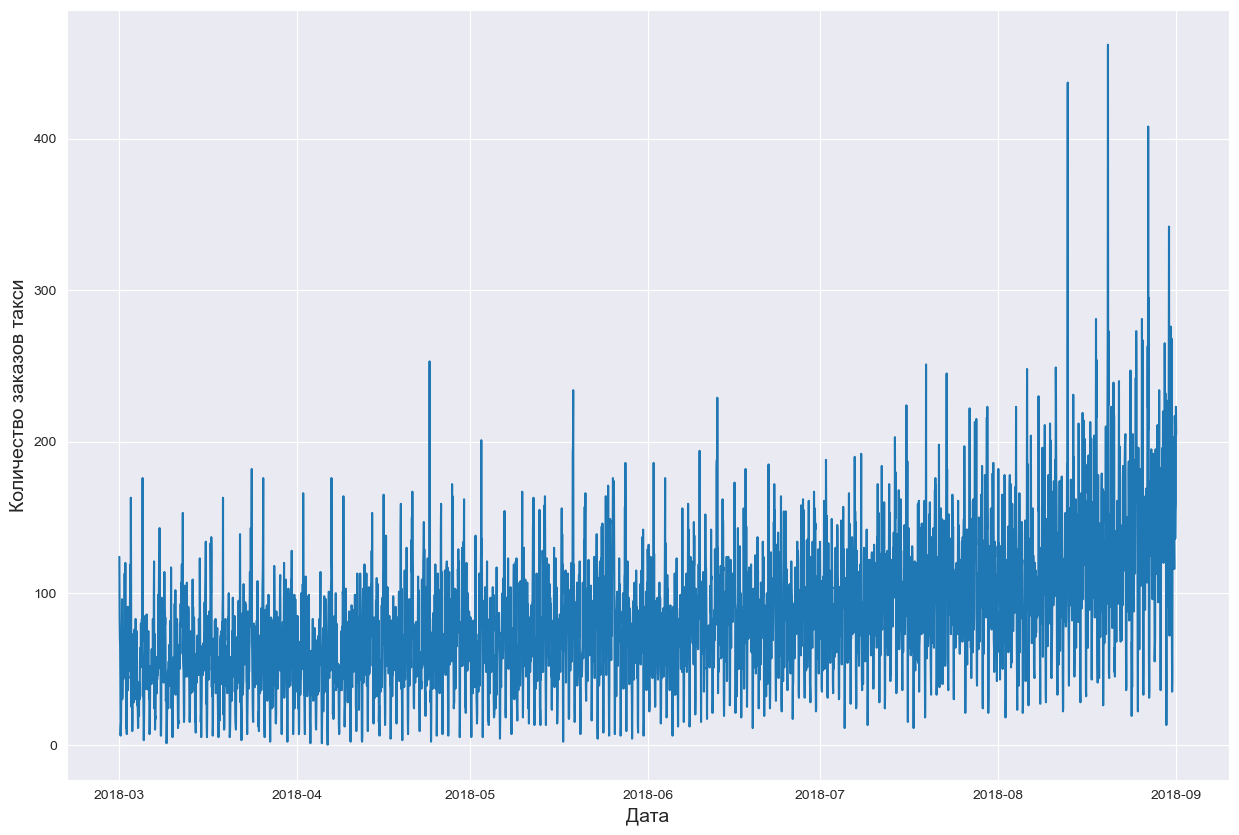

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.lineplot(data=data['num_orders'])

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество заказов такси', fontsize=14);

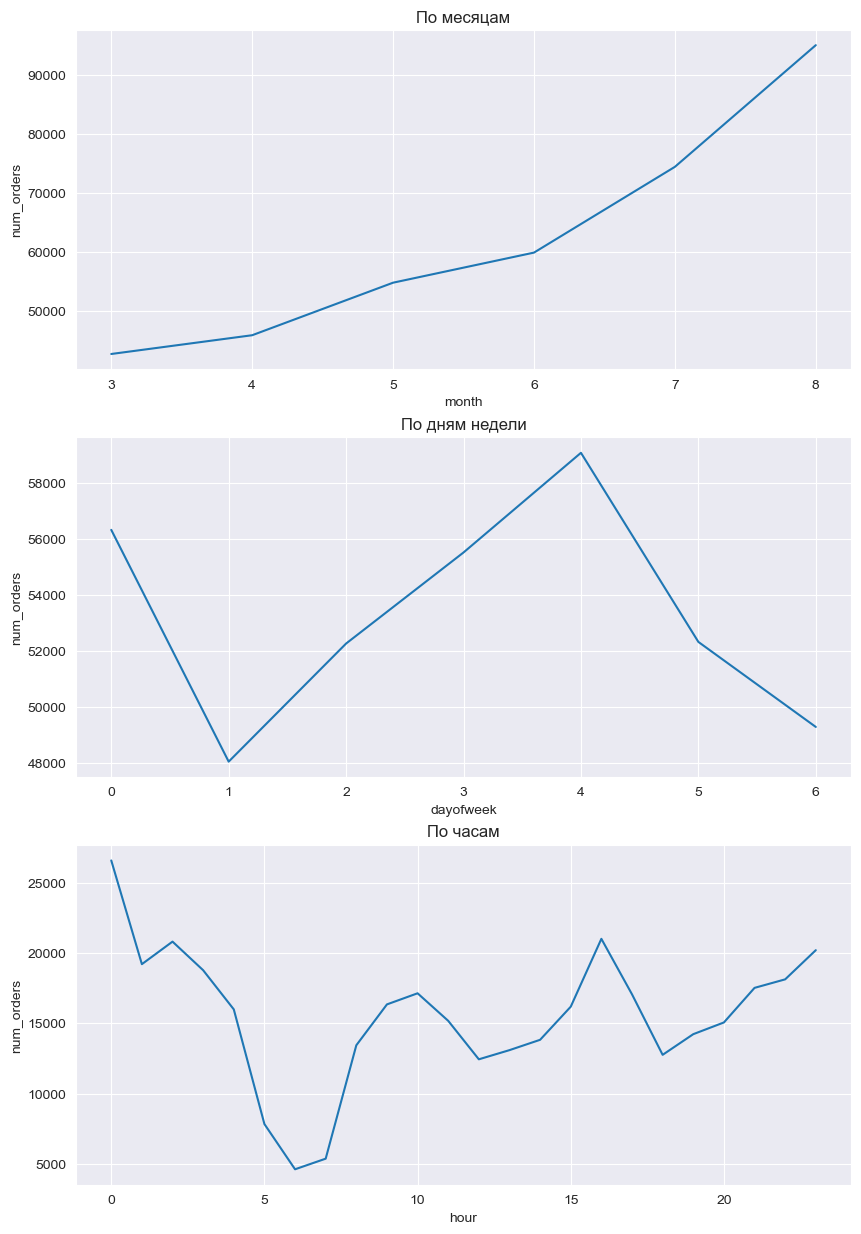

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(data=data.groupby('month')['num_orders'].sum(), ax=ax[0]).set(title='По месяцам')
sns.lineplot(data=data.groupby('dayofweek')['num_orders'].sum(), ax=ax[1]).set(title='По дням недели')
sns.lineplot(data=data.groupby('hour')['num_orders'].sum(), ax=ax[2]).set(title='По часам');

По графикам можно сразу увидеть некоторые закономерности:

- Чаще всего заказывают такси ближе к выходным
- Весь день относительно стабильно заказывают такси, лишь наблюдается просадка с 4 - 7.
- По какой-то причине с каждым месяцем заказывают все больше и больше такси (вероятно из-за увелечения популярности сервиса).

In [14]:
decomposed = seasonal_decompose(data['num_orders'])

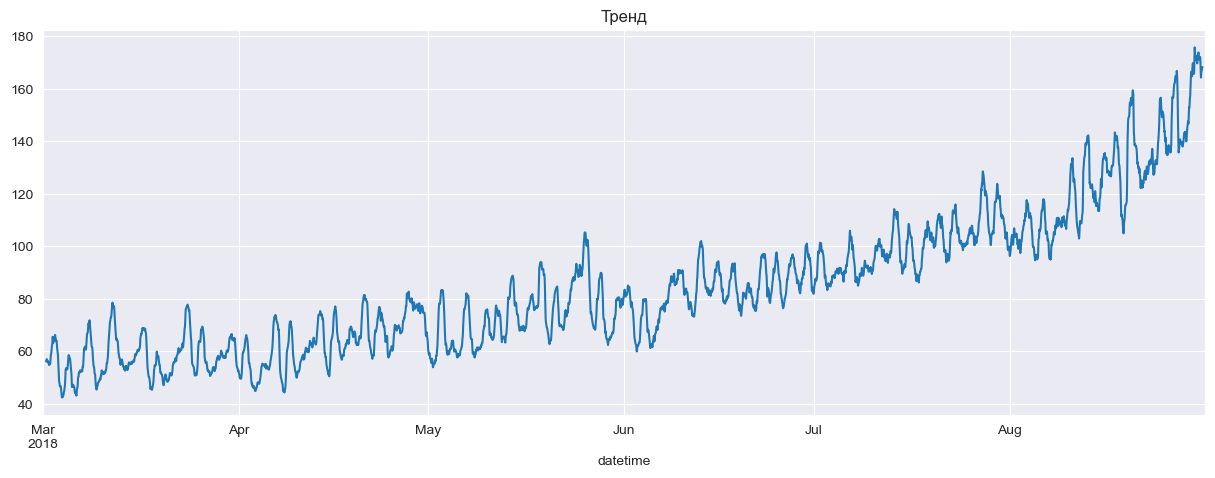

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))

decomposed.trend.plot(ax=plt.gca())

plt.title('Тренд');

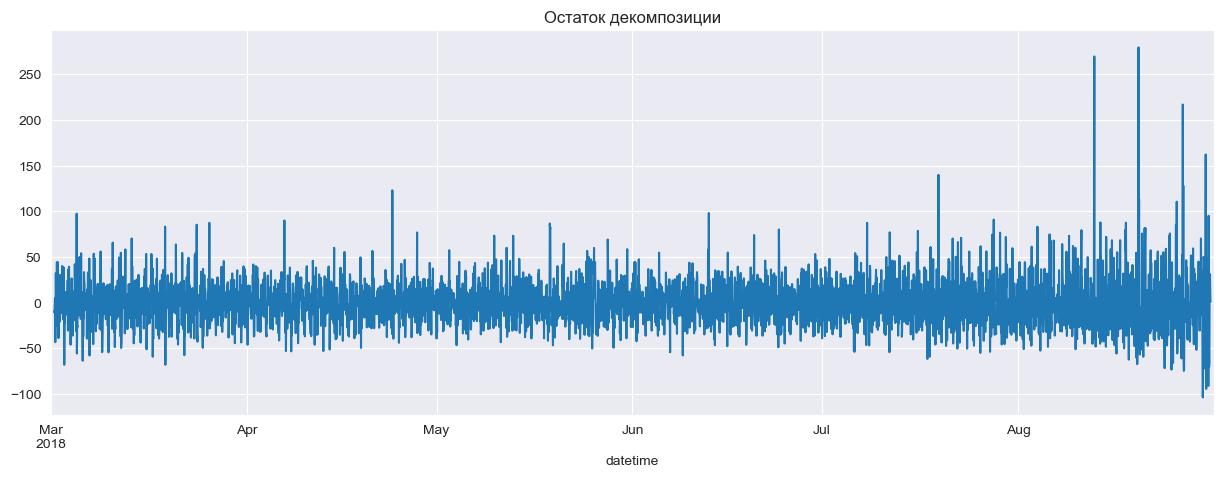

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))

decomposed.resid.plot(ax=plt.gca())

plt.title('Остаток декомпозиции');

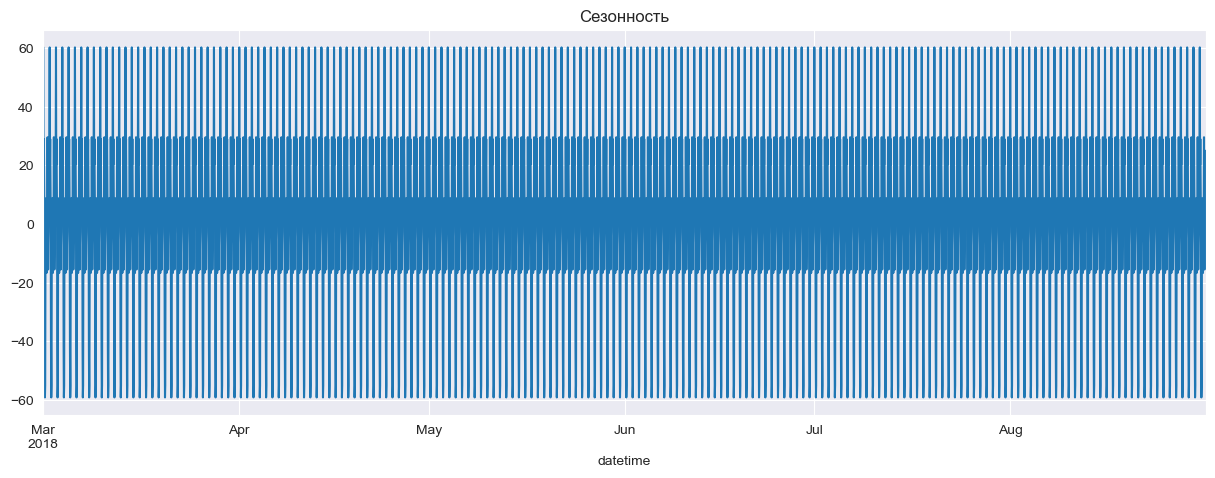

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))

decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность');

Возьмем меньший промежуток, чтобы удобнее было изучать.

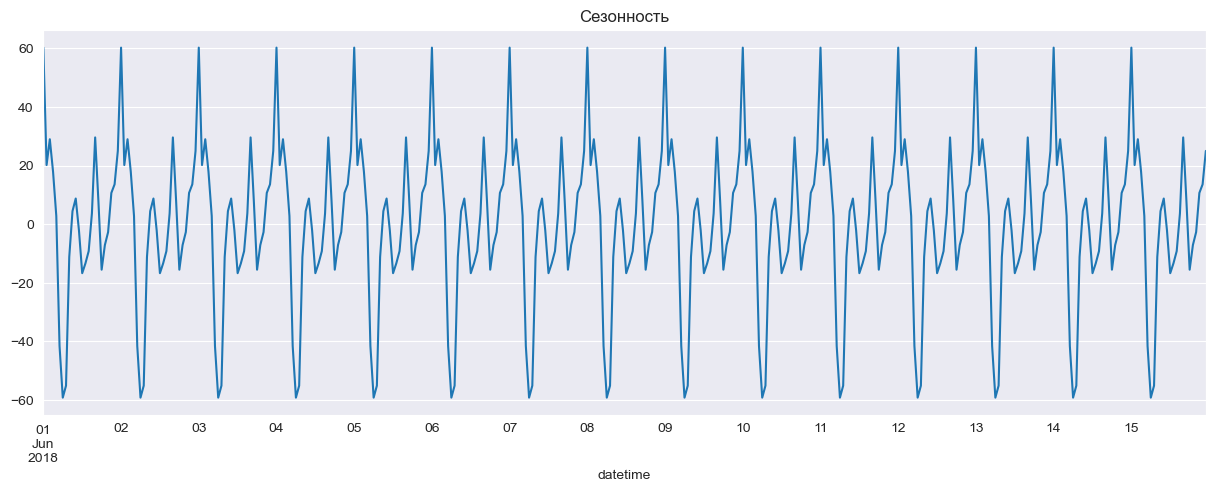

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))

decomposed.seasonal['2018-06-01':'2018-06-15'].plot(ax=plt.gca())

plt.title('Сезонность');

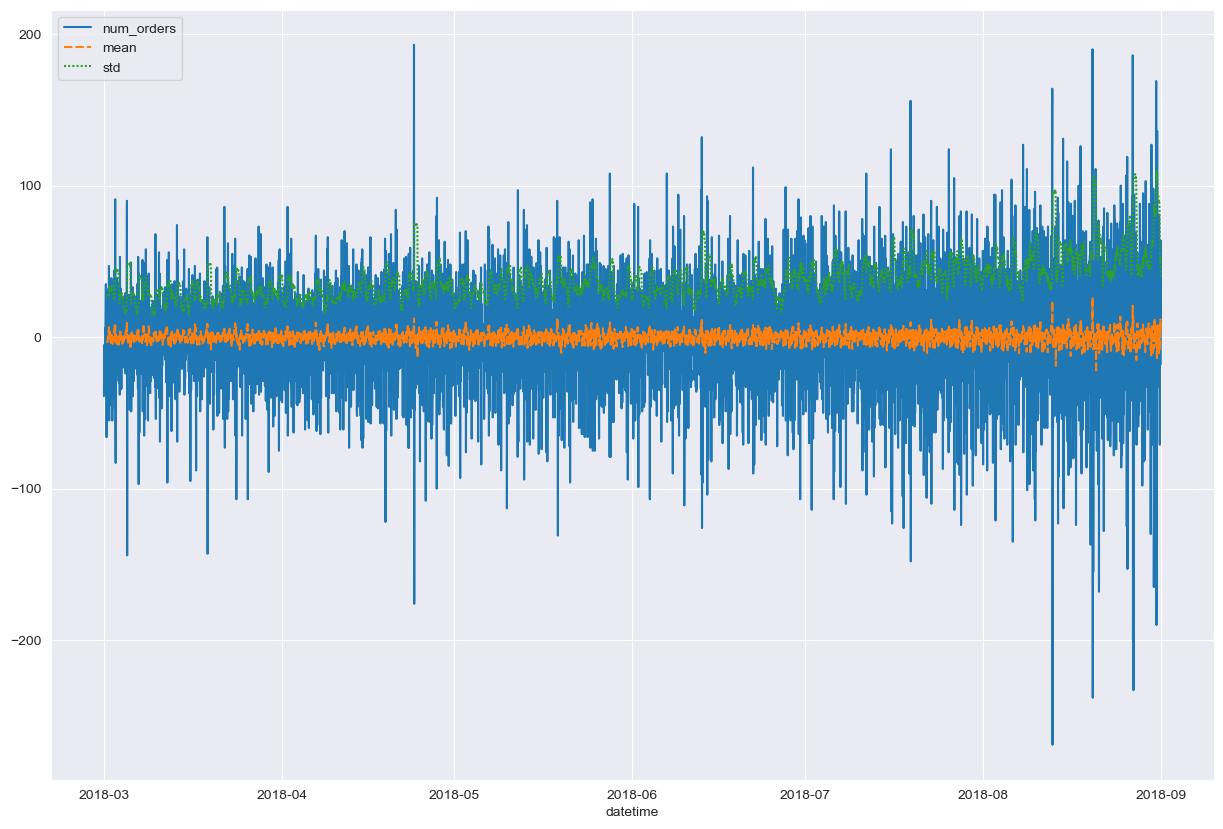

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
temp = data - data.shift()

temp = temp[['num_orders']]
temp['mean'] = temp['num_orders'].rolling(15).mean()
temp['std'] = temp['num_orders'].rolling(15).std()

sns.lineplot(data=temp);

Вывод:
- Временной ряд - `стационарный`
- Имеется тренд по увеличению количества заказов
- Пики заказов к `24` и в `16`.
- Самый нагруженный день - `пятница`

## Обучение

In [20]:
# Эта константа понадобится для обучения моделей
tsscv = TimeSeriesSplit(n_splits = 4)

In [21]:
train, test = train_test_split(data, shuffle=False, test_size=.1)

In [22]:
train_features = train.drop(['num_orders'], axis=1).dropna()
train_target = train.iloc[train.shape[0] - train_features.shape[0]:]['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Создадим функцию для обучения моделей.

In [23]:
def learn(mod, params):
    
    if mod == CatBoostRegressor:
        model = CatBoostRegressor(logging_level='Silent')
    else:
        model = mod()
        
    #model.fit(train_features, train_target)
    #pred = model.predict(valid_features)
    #rmse = np.sqrt(mse(valid_target, pred))
    
    # print('\nBase model - {}\nRMSE:{}\n'.format(model, '%.2f' % rmse))
    
    parameters = params
    tsscv = TimeSeriesSplit(n_splits = 4) 
    
    grid = GridSearchCV(model, parameters, cv=tsscv, scoring='neg_root_mean_squared_error', verbose=False)
    grid.fit(train_features, train_target)
    
    if mod == CatBoostRegressor:
         model_tuned = mod(**grid.best_params_, logging_level='Silent').fit(train_features, train_target)
    else:
        model_tuned = mod(**grid.best_params_).fit(train_features, train_target)
        
    rmse_tuned = grid.best_score_ * -1
    
    print('Tuned model - {}\nRMSE:{}\n'.format(model, rmse_tuned))
        
    return model, model_tuned, rmse_tuned

### LinearRegression

In [24]:
%%time

lr_model, lr_model_tuned, lr_rmse_tuned = learn(
    LinearRegression, {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]})

### CatBoostRegressor

In [25]:
%%time

cat_model, cat_model_tuned, cat_rmse_tuned = learn(
    CatBoostRegressor, {'iterations': [1000],
                        'learning_rate': [0.1, 1, 0.2],
                        'depth': [5, 10]}
)

### LGBMRegressor

In [26]:
%%time

lgb_model, lgb_model_tuned, lgb_rmse_tuned = learn(
    LGBMRegressor, {"n_estimators": [100, 200],
                    "max_depth": [2, 4, 6]}
)

### Вывод

Наилучший результат показала модель `CatBoostRegressor`, потому именно ее мы и будем использовать.

## Тестирование

In [28]:
fin_pred = lgb_model_tuned.predict(test_features)
rmse_tun = np.sqrt(mse(test_target, fin_pred))

print('RMSE лучшей модели: {}'.format(rmse_tun))

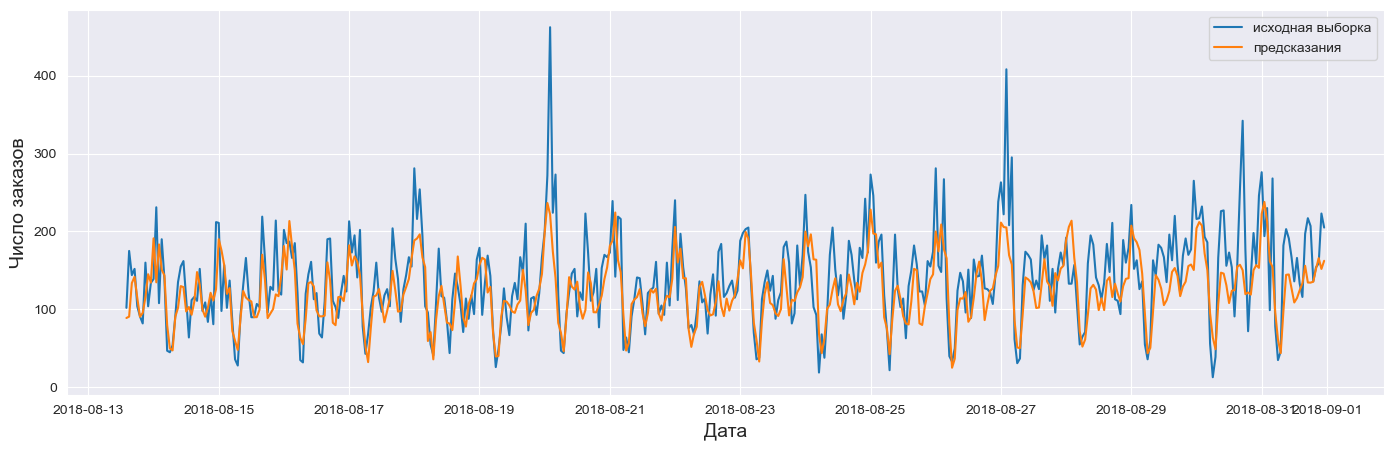

In [29]:
predictions_test = pd.Series(fin_pred, index=test_target.index)

# Визуализируем предсказанные значения и реальные
fig, ax = plt.subplots(figsize=(17, 5))

plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число заказов', fontsize=14)

sns.lineplot(data=test_target, label='исходная выборка')
sns.lineplot(data=predictions_test, label='предсказания')

plt.legend(fontsize=10);

## Вывод

1) Мы проанализировали данные:
 - Временной ряд - стационарный
 - Имеется тренд по увеличению количества заказов
 - Пики заказов к 24 и в 16.
 - Самый нагруженный день - пятница

2) Протестировав несколько моделей, мы выбрали одну лучшую. Ею оказалась `CatBoostRegressor`.

3) Протестировали модель на тестовых данных и получили значение RMSE `42.8`.